# Test 1 - Site explicit modelling under Mott-Schottky conditions.

**Running the code in this notebook takes approximately 2 minutes. (iMac with 4 Ghz i7 processor).**

This notebook can be run to verify that the code is working as expected using the site explicit model under Mott-Schottky conditions, without including the additional site charge.
The data collected by running this notebook is a DataFrame, saved in `output_data.csv` which contains information about the conditions applied to the calculation, the $x$ coordinate data, and the calculated electrostatic potential, charge density and input and output defect mole fraction. A DataFrame stored in `key_data.dat`, which includes the calculated space charge properties and a saved figure for the elctrostatic potential, charge density and defect mole fractions as a function of $x$.
The outputs from running this notebook will be stored in the `generated_outputs` directory and can be compared to the controlled outputs previously calculated in `expected_outputs` directory. 

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.set_up_calculation import calculate_grid_offsets
from pyscses.grid import Grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.isdir('generated_outputs'):
    os.mkdir('generated_outputs')

In [3]:
boundary_conditions = 'periodic'
site_charges = False
systems = 'mott-schottky'
core_models = False
site_models = 'site_explicit'
scaling = True

In [4]:
alpha = 0.0005
conv = 1e-6
grid_x_min = -6.094e-9
grid_x_max = 5.16e-9
bulk_x_min = -5.783e-9
bulk_x_max = -2.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 773.15 ]

In [5]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.05, 0.2 ] ])
initial_guess = np.array([ [ 0.05, 0.2 ] ])
mobilities = [ 1.0, 0.0 ]

In [6]:
data = '../input_data/Gd_CeO2_111_data.txt'

In [7]:
labels=[ 'core_model', 'site_model', 'MS_GC', 'site_charge', 'resistivity_scaling', 'temperature', 'input_mole_fractions', 'x', 'phi', 'rho', 'Vo_mole_fraction', 'Gd_mole_fraction']
output_data = pd.DataFrame( columns=labels )
filename = 'generated_outputs/output_data.csv'

In [8]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems, verbose=True)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )
        
        output_data['x'] = grid.x
        output_data['phi'] = c_o.phi
        output_data['rho'] = c_o.rho
        output_data['Vo_mole_fraction'] = c_o.mf[site_labels[0]]
        output_data['Gd_mole_fraction'] = c_o.mf[site_labels[1]]
        output_data['core_model'] = str(core_models)
        output_data['site_model'] = str(site_models)
        output_data['MS_GC'] = str(systems)
        output_data['site_charge'] = str(site_charges)
        output_data['resistivity_scaling'] = str(scaling)
        output_data['temperature'] = t
        output_data['input_mole_fractions'] = str(m)
        output_data.to_csv(filename, index=False)
        
        key_data = np.column_stack(( max(c_o.phi), c_o.perpendicular_resistivity_ratio, c_o.parallel_resistivity_ratio ))
        np.savetxt('generated_outputs/key_data.dat', key_data)

Iteration: 500 -> Convergence: 0.007447986294976805 / 1e-06
Iteration: 1000 -> Convergence: 0.0007754893152833815 / 1e-06
Iteration: 1500 -> Convergence: 0.00018699456659750744 / 1e-06
Iteration: 2000 -> Convergence: 6.407008310764769e-05 / 1e-06
Iteration: 2500 -> Convergence: 2.641345352581461e-05 / 1e-06
Iteration: 3000 -> Convergence: 1.2241838100617005e-05 / 1e-06
Iteration: 3500 -> Convergence: 6.144657281250713e-06 / 1e-06
Iteration: 4000 -> Convergence: 3.2588703205936678e-06 / 1e-06
Iteration: 4500 -> Convergence: 1.7952087978299646e-06 / 1e-06
Iteration: 5000 -> Convergence: 1.015070044794803e-06 / 1e-06
Converged at iteration 5014 -> Convergence: 9.9928313960665e-07 / 1e-06


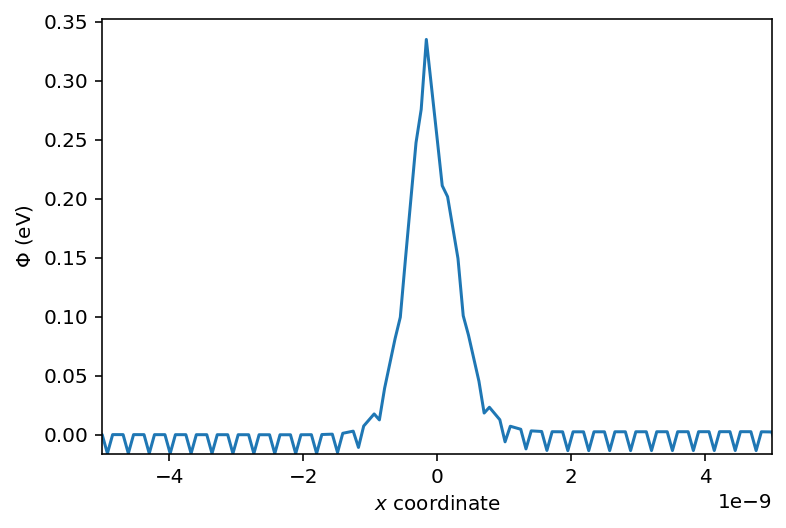

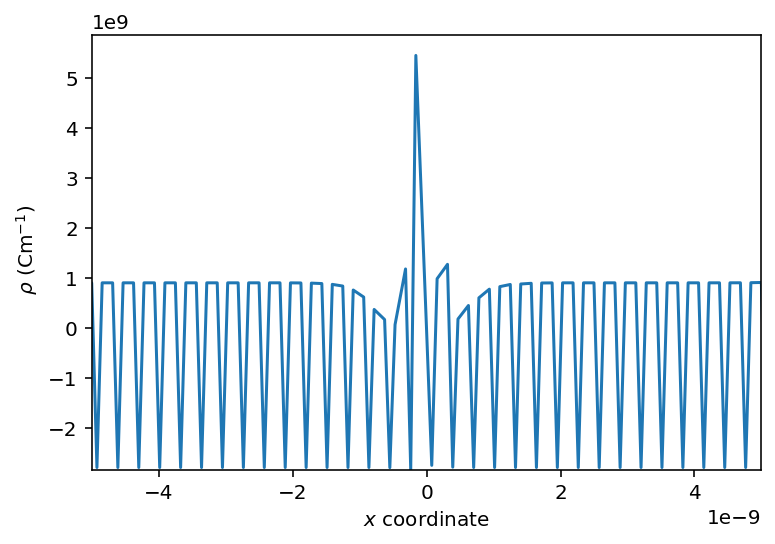

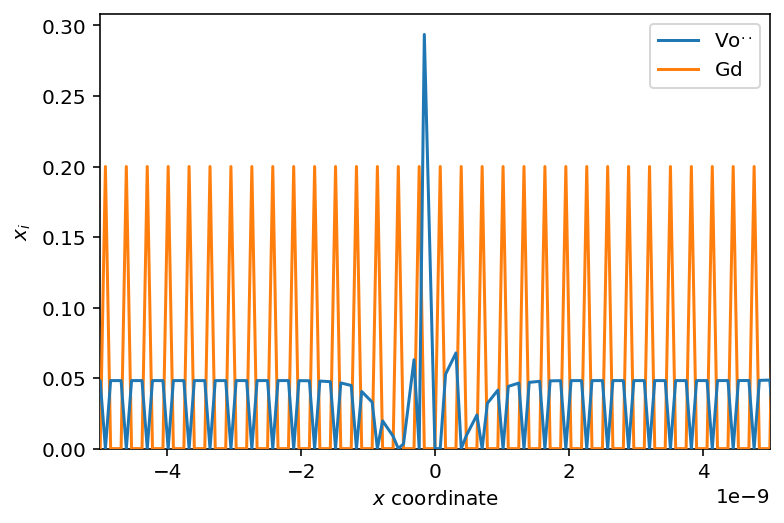

In [9]:
# from fig_params import rcParams
# import fig_params as fp
# rcParams.update( fp.transitionfig_formatting)
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.xlim(-5e-9, 5e-9)
plt.ylim(min(c_o.phi))
plt.savefig('generated_outputs/x_vs_potential.pdf')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $ \\rho $ $(\mathrm{C m}^{-1})$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(min(c_o.rho))
plt.savefig('generated_outputs/x_vs_chargedensity.pdf')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{Vo}^{..}$', zorder = 5.0)
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{Gd}$', zorder = 4.0)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(0.0)
plt.legend()
plt.savefig('generated_outputs/x_vs_molefractions.pdf')
plt.show()